<a href="https://colab.research.google.com/github/gnodking7/WDAnepv/blob/main/Example_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
In this example, we use Synthetic Shape datasets to demonstrate the classification accuracy of WDA-nepv in comparison to those of WDA-gd [1] and WDA-eig [3].

We will go over the background of the example in the following order:
1.   What are Synthetic Shape datasets?
2.   What are WDA-nepv, WDA-gd, and WDA-eig?
3.   Example Setup

### What are Synthetic Shape datasets?
Synthetic Shape datasets are synthetically created two dimensional datasets. These datasets are available at http://cs.joensuu.fi/sipu/datasets/. We consider Jain, Flame, Pathbased, Compound, Aggregation, and R15 datasets.

8 additional components drawn from the standard normal distribution $\mathcal{N}(0,1)$ are appended to each dataset. Then, each dataset is standardized.

The plots of the first two components of each dataset are shown below:

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [ ]:
!pip install pymanopt
!pip install autograd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import WDA_datasets as datasets
import WDAnepv
import WDAgd
import WDAeig
import numpy as np
import matplotlib.pylab as pl

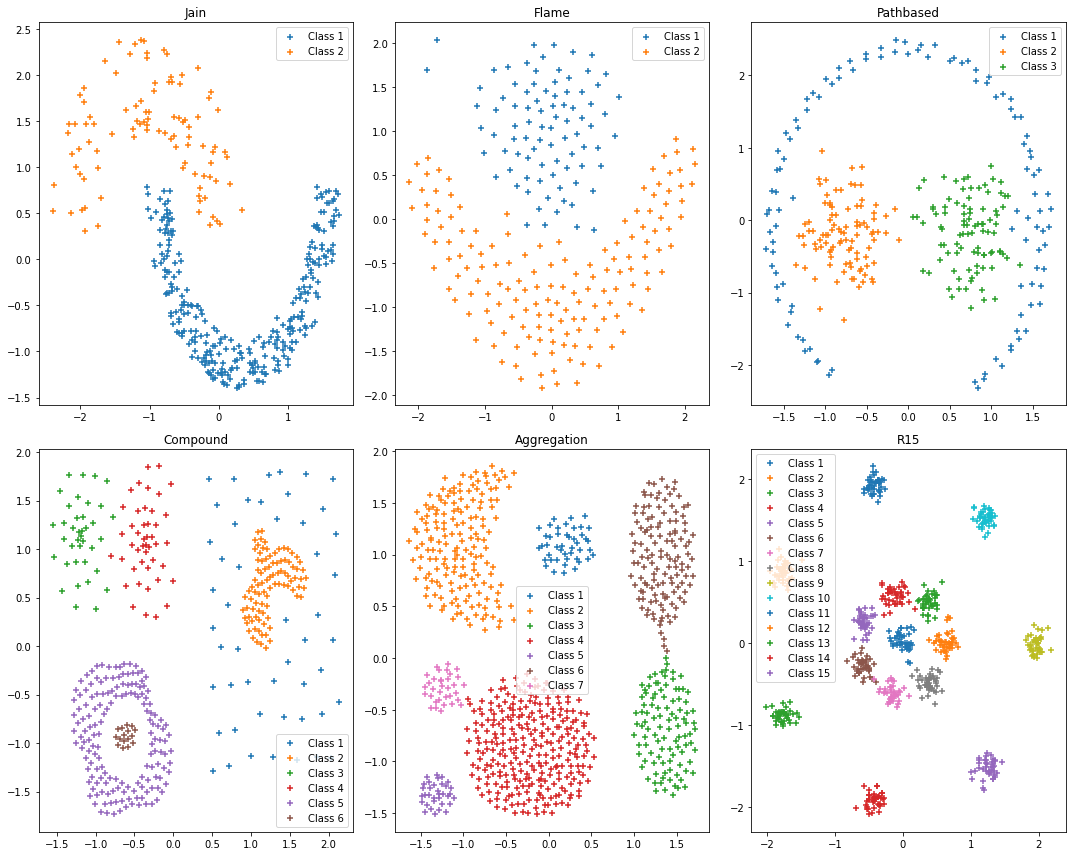

In [ ]:
# Load Synthetic Shape datasets
jain_TR, jain_TR_L, jain_TST, jain_TST_L = datasets.load_shape('jain')
jain = np.vstack((jain_TR, jain_TST))
jain_label = np.concatenate((jain_TR_L, jain_TST_L))

flame_TR, flame_TR_L, flame_TST, flame_TST_L = datasets.load_shape('flame')
flame = np.vstack((flame_TR, flame_TST))
flame_label = np.concatenate((flame_TR_L, flame_TST_L))

pathbased_TR, pathbased_TR_L, pathbased_TST, pathbased_TST_L = datasets.load_shape('pathbased')
pathbased = np.vstack((pathbased_TR, pathbased_TST))
pathbased_label = np.concatenate((pathbased_TR_L, pathbased_TST_L))

compound_TR, compound_TR_L, compound_TST, compound_TST_L = datasets.load_shape('compound')
compound = np.vstack((compound_TR, compound_TST))
compound_label = np.concatenate((compound_TR_L, compound_TST_L))

aggregation_TR, aggregation_TR_L, aggregation_TST, aggregation_TST_L = datasets.load_shape('aggregation')
aggregation = np.vstack((aggregation_TR, aggregation_TST))
aggregation_label = np.concatenate((aggregation_TR_L, aggregation_TST_L))

r15_TR, r15_TR_L, r15_TST, r15_TST_L = datasets.load_shape('r15')
r15 = np.vstack((r15_TR, r15_TST))
r15_label = np.concatenate((r15_TR_L, r15_TST_L))

# Plots of first two components that are discriminatory
pl.figure(1, figsize=(15, 12))

pl.subplot(2,3,1)
labels = np.unique(jain_label)
for i in range(len(labels)):
    label = int(labels[i])
    pl.scatter(jain[np.where(jain_label==label), 0], jain[np.where(jain_label==label), 1], marker='+', label='Class ' + str(i + 1))
pl.title('Jain')
pl.legend()

pl.subplot(2,3,2)
labels = np.unique(flame_label)
for i in range(len(labels)):
    label = int(labels[i])
    pl.scatter(flame[np.where(flame_label==label), 0], flame[np.where(flame_label==label), 1], marker='+', label='Class ' + str(i + 1))
pl.title('Flame')
pl.legend()

pl.subplot(2,3,3)
labels = np.unique(pathbased_label)
for i in range(len(labels)):
    label = int(labels[i])
    pl.scatter(pathbased[np.where(pathbased_label==label), 0], pathbased[np.where(pathbased_label==label), 1], marker='+', label='Class ' + str(i + 1))
pl.title('Pathbased')
pl.legend()

pl.subplot(2,3,4)
labels = np.unique(compound_label)
for i in range(len(labels)):
    label = int(labels[i])
    pl.scatter(compound[np.where(compound_label==label), 0], compound[np.where(compound_label==label), 1], marker='+', label='Class ' + str(i + 1))
pl.title('Compound')
pl.legend()

pl.subplot(2,3,5)
labels = np.unique(aggregation_label)
for i in range(len(labels)):
    label = int(labels[i])
    pl.scatter(aggregation[np.where(aggregation_label==label), 0], aggregation[np.where(aggregation_label==label), 1], marker='+', label='Class ' + str(i + 1))
pl.title('Aggregation')
pl.legend()

pl.subplot(2,3,6)
labels = np.unique(r15_label)
for i in range(len(labels)):
    label = int(labels[i])
    pl.scatter(r15[np.where(r15_label==label), 0], r15[np.where(r15_label==label), 1], marker='+', label='Class ' + str(i + 1))
pl.title('R15')
pl.legend()

pl.tight_layout()

### What are WDA-nepv, WDA-gd, and WDA-eig?
WDA-nepv, WDA-gd, and WDA-eig are algorithms that solves Wasserstein Discriminant Analysis (WDA) [1]:
$$\max_{\mathbf{P}^T\mathbf{P}=I_p}\frac{\mbox{tr}(\mathbf{P}^T\mathbf{C}_b(\mathbf{P})\mathbf{P})}{\mbox{tr}(\mathbf{P}^T\mathbf{C}_w(\mathbf{P})\mathbf{P})}$$
where $\mathbf{C}_b(\mathbf{P})$ and $\mathbf{C}_w(\mathbf{P})$
are defined as the between and within cross-covariance matrices
$$\mathbf{C}_b(\mathbf{P}_k) = \sum_{c,c'>c}  \sum_{ij}{T}_{ij}^{c,c'}(\mathbf{P}_k)(\mathbf{x}_i^c-\mathbf{x}_j^{c'})(\mathbf{x}_i^c-\mathbf{x}_j^{c'})^T$$
$$\mathbf{C}_w(\mathbf{P}_k) = \sum_c  \sum_{ij}{T}_{ij}^{c,c}(\mathbf{P}_k)(\mathbf{x}_i^c-\mathbf{x}_j^{c})(\mathbf{x}_i^c-\mathbf{x}_j^{c})^T $$
The matrices $\mathbf{T}^{c,c'}$ and $\mathbf{T}^{c,c}$ are transport matrices and can be computed using Acc_SK. See Example 2 for the discussion of transport matrices and Acc_SK.

WDA-gd is a steepest-descent algorithm and incurs extra costs for computing the gradients. WDA-eig solves a nonlinear generalized eigenvalue problem associated with an approximate problem to WDA.

WDA-nepvs is gradient-free and makes no approximation to WDA. In a nutshell, WDA-nepv can be described as an algorithm that iteratively updates the projection matrix $\mathbf{P}_k$ by 
$$\mathbf{P}_{k+1} = \mbox{argmax}_{\mathbf{P}^T\mathbf{P}=I_p}
\frac{\mbox{tr}(\mathbf{P}^T\mathbf{C}_b(\mathbf{P}_k)\mathbf{P})}
{\mbox{tr}(\mathbf{P}^T\mathbf{C}_w(\mathbf{P}_k)\mathbf{P})}$$
which, as a standard trace ratio problem, can be solved by the Self-Consistent-Field (SCF) method [2].

### Example Setup
As a supervised linear dimensionality reduction method, WDA seeks an optimal projection such that the class structure of the projected data vectors becomes more pronounced. For this reason, the effectiveness of WDA is measured by the classification accuracy.

Following the standard practice in classification tasks, each Synthetic Shape dataset is divided into the training dataset and the testing dataset. In this example, we consider 50% training and 50% testing split. After the algorithm is trained on the training dataset and an optimal projection matrix $\mathbf{P}$ is obtained, the testing dataset is then projected onto a lower dimensional subspace using this projection $\mathbf{P}$. Then, the classification accuracy of the algorithm is measured by using K-Nearest-Neighbors classifier (KNN) on the projected testing dataset. 

Since the first two components of Synthetic Shape datasets are discriminating, the projected subspace dimension is fixed at $p=2$. The number of neighbors in KNN is chosen as $K=10$. The classification accuracy for WDA-gd, WDA-eig, and WDA-nepv for various regularization parameter $\lambda=0.1,1,5$ are reported. Initial projection matrix $\mathbf{P}_0$ is randomly chosen. All classification results are averaged over 100 trials.

In [ ]:
# Call KNN package
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# Define a runner function
def classification_runner(dataset, p, reg, K):
    """
    A runner function for performing classification experiments,
    solving Wasserstein Discriminant Analysis (WDA) using
    WDAgd, WDAeig, WDAnepv

    PARAMETERS
    ----------
    dataset :       string
                    Name of dataset
    p :             int
                    Size of subspace dimension
    reg :           float
                    Wasserstein regularization parameter > 0
    K :             int
                    Number of neighbors in KNN
    """

    print('Performing classification for:', dataset, 'with subspace dim', p, ', reg param', reg, ', and KNN K=', K)
    print('--------------------------------------------------------------------------------------------')

    # success rate
    acclist_gd = []
    acclist_eig = []
    acclist_nepv = []

    # elapsed time
    time_gd = []
    time_eig = []
    time_nepv = []

    n_trial = 100

    # trials
    for i in range(n_trial):
        # load dataset
        if dataset == 'jain':
            TR, TR_L, TST, TST_L = datasets.load_shape('jain')
        elif dataset == 'flame':
            TR, TR_L, TST, TST_L = datasets.load_shape('flame')
        elif dataset == 'pathbased':
            TR, TR_L, TST, TST_L = datasets.load_shape('pathbased')
        elif dataset == 'compound':
            TR, TR_L, TST, TST_L = datasets.load_shape('compound')
        elif dataset == 'aggregation':
            TR, TR_L, TST, TST_L = datasets.load_shape('aggregation')
        elif dataset == 'r15':
            TR, TR_L, TST, TST_L = datasets.load_shape('r15')

        # Wasserstein Discriminant Analysis
        d = TR.shape[1]
        x0 = np.random.randn(d, p)
        P0, r = np.linalg.qr(x0)  # random initial projection

        start1 = time.time()
        Pgd, proj1, Itr1, PROJ1 = WDAgd.wda_gd(TR, TR_L, p, reg, P0)    # WDAgd
        end1 = time.time()
        time1 = end1 - start1
        time_gd.append(time1)

        start2 = time.time()
        Peig, proj2, WDA_Val2, PROJ2, Sub_Err2 = WDAeig.wda_eig(TR, TR_L, p, reg, P0)   # WDAeig
        end2 = time.time()
        time2 = end2 - start2
        time_eig.append(time2)

        start3 = time.time()
        Pnepv, proj3, WDA_Val3, PROJ3, Sub_Err3 = WDAnepv.wda_nepv(TR, TR_L, p, reg, P0, tol=1e-8)  # WDAnepv
        end3 = time.time()
        time3 = end3 - start3
        time_nepv.append(time3)

        # KNN models
        model1 = KNeighborsClassifier(n_neighbors=K)
        model1.fit(proj1(TR), TR_L)
        model2 = KNeighborsClassifier(n_neighbors=K)
        model2.fit(proj2(TR), TR_L)
        model3 = KNeighborsClassifier(n_neighbors=K)
        model3.fit(proj3(TR), TR_L)

        # Test
        predicted1 = model1.predict(proj1(TST))
        acc1 = accuracy_score(TST_L, predicted1)
        predicted2 = model2.predict(proj2(TST))
        acc2 = accuracy_score(TST_L, predicted2)
        predicted3 = model3.predict(proj3(TST))
        acc3 = accuracy_score(TST_L, predicted3)

        # store accuracy
        acclist_gd.append(acc1)
        acclist_eig.append(acc2)
        acclist_nepv.append(acc3)

    # Print results
    print('WDAgd: mean is', np.mean(acclist_gd), 'with standard deviation', np.std(acclist_gd))
    print('Average elapsed time:', np.mean(time_gd))
    print('WDAeig: mean is', np.mean(acclist_eig), 'with standard deviation', np.std(acclist_eig))
    print('Average elapsed time:', np.mean(time_eig))
    print('WDAnepv: mean is', np.mean(acclist_nepv), 'with standard deviation', np.std(acclist_nepv))
    print('Average elapsed time:', np.mean(time_nepv))


In [ ]:
# Perform exmperiments for reg param = 0.1
classification_runner('jain', 2, 0.1, 10)
classification_runner('flame', 2, 0.1, 10)
classification_runner('pathbased', 2, 0.1, 10)
classification_runner('compound', 2, 0.1, 10)
classification_runner('aggregation', 2, 0.1, 10)
classification_runner('r15', 2, 0.1, 10)

Performing classification for: jain with subspace dim 2 , reg param 0.1 , and KNN K= 10
--------------------------------------------------------------------------------------------
WDAgd: mean is 0.9546236559139786 with standard deviation 0.018284629280860214
Average elapsed time: 22.974278757572176
WDAeig: mean is 0.9325268817204302 with standard deviation 0.017210600325278647
Average elapsed time: 2.635434114933014
WDAnepv: mean is 0.9533870967741934 with standard deviation 0.018516100932877425
Average elapsed time: 0.33070518732070925
Performing classification for: flame with subspace dim 2 , reg param 0.1 , and KNN K= 10
--------------------------------------------------------------------------------------------
WDAgd: mean is 0.8865000000000001 with standard deviation 0.0399614397471696
Average elapsed time: 19.593161273002625
WDAeig: mean is 0.9498333333333332 with standard deviation 0.03242469909052528
Average elapsed time: 0.848813841342926
WDAnepv: mean is 0.8681666666666666 w

In [ ]:
# Perform exmperiments for reg param = 1
classification_runner('jain', 2, 1, 10)
classification_runner('flame', 2, 1, 10)
classification_runner('pathbased', 2, 1, 10)
classification_runner('compound', 2, 1, 10)
classification_runner('aggregation', 2, 1, 10)
classification_runner('r15', 2, 1, 10)

Performing classification for: jain with subspace dim 2 , reg param 1 , and KNN K= 10
--------------------------------------------------------------------------------------------
WDAgd: mean is 0.9432258064516128 with standard deviation 0.035559710417432736
Average elapsed time: 69.32742908716202
WDAeig: mean is 0.943978494623656 with standard deviation 0.02586440625057685
Average elapsed time: 6.020595693588257
WDAnepv: mean is 0.9779569892473119 with standard deviation 0.017128529378574175
Average elapsed time: 3.2151760959625246
Performing classification for: flame with subspace dim 2 , reg param 1 , and KNN K= 10
--------------------------------------------------------------------------------------------
WDAgd: mean is 0.8968333333333334 with standard deviation 0.06713150444380707
Average elapsed time: 18.53214635133743
WDAeig: mean is 0.9356666666666666 with standard deviation 0.054353268326548465
Average elapsed time: 1.3583952236175536
WDAnepv: mean is 0.9402499999999999 with st

In [ ]:
# Perform exmperiments for reg param = 5
classification_runner('jain', 2, 5, 10)
classification_runner('flame', 2, 5, 10)
classification_runner('pathbased', 2, 5, 10)
classification_runner('compound', 2, 5, 10)
classification_runner('aggregation', 2, 5, 10)
classification_runner('r15', 2, 5, 10)

Performing classification for: jain with subspace dim 2 , reg param 5 , and KNN K= 10
--------------------------------------------------------------------------------------------


# References

[1] R ́emi Flamary, Marco Cuturi, Nicolas Courty, and Alain Rakotomamonjy. Wasserstein dis-
criminant analysis. Machine Learning, 107(12):1923–1945, 2018.

[2] Lei-Hong Zhang, Li-Zhi Liao, and Michael K Ng. Fast algorithms for the generalized foley–
sammon discriminant analysis. SIAM journal on matrix analysis and applications, 31(4):1584–
1605, 2010.

[3] Hexuan Liu, Yunfeng Cai, You-Lin Chen, and Ping Li. Ratio trace formulation of wasserstein
discriminant analysis. Advances in Neural Information Processing Systems, 33, 2020.